In this notebook, we may test the algorithm's properties on synthetic datasets

### 0- Library importation

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from src.utils import *
from src.algorithms import * 
from src.metrics_FAMD import *

import warnings
warnings.filterwarnings('ignore')

### 1- Set general parameters

In [76]:
np.random.seed(21032024) # Set random seed to create reproductible results

# Number of simulations to run
n_simulations = 200

# Probabilities to inject missing values into the dataframe
proba_non_missing = [0.7, 0.8, 0.9]

# Maximum number iterations for iFAMD convergence 
n_it = 1000

### 2- Test properties on synthetic datasets

#### 2.1 Relationships between continuous and categorical variables: Impact of SNR

##### 2.1.a - Parameter definition 

In [77]:
#Parameters of the first dataset created in the paper : (3.1 Relationships between continuous and categorical variables)

n = 100 # Sample size
S = 2  # Underlying dimensions
K = [1,3]  #K[s] = number of times the variable s (s in {1,...,S}) is duplicated in the dataset
cat = 2 #number of categorical variables
cat_idx = [1,2] #index of the categorical variables
nb_of_cat_per_var = [4,4] #number of categories for each categorical variable

# Number of components for reconstruction 
n_components = 2

##### 2.1.b - Run simulations 

In [78]:
# Create lists where we will save progressively the scores 
nrmse_1, nrmse_3 = [], [] # NRMSE (for SNR=1,3)
fc_rate_saved1, fc_rate_saved3 = [], [] # Falsely classified rate (for SNR=1,3)

# We run all simulations
for n_sim in range(n_simulations):
    # For SNR = 1: 
    ##Create dataset 
    df_1_1_snr1 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, 1)
    ## Compute iFAMD and metrics
    fc_rate_1, nmrse_1, dc = compute_metrics(df_1_1_snr1, pd.Index(cat_idx).map(str), n_it, n_components, proba_non_missing)
    ## Save scores 
    fc_rate_saved1.append(fc_rate_1)
    nrmse_1.append(nmrse_1)

    # For SNR = 3: 
    ## Create dataset
    df_3_1_snr3 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, 3)
    ## Compute iFAMD and metrics
    fc_rate_3, nmrse_3, _ = compute_metrics(df_3_1_snr3, pd.Index(cat_idx).map(str), n_it, n_components, proba_non_missing)
    ## Save scores 
    fc_rate_saved3.append(fc_rate_3)
    nrmse_3.append(nmrse_3)


# Normalization of scores over all iterations 
fc_rate_saved1, fc_rate_saved3= np.array(fc_rate_saved1).mean(axis=0), np.array(fc_rate_saved3).mean(axis=0)
nrmse_snr1, nrmse_snr3 = np.array(nrmse_1).mean(axis=0), np.array(nrmse_3).mean(axis=0)

Converged in 9
Converged in 9
Converged in 5
Converged in 7
Converged in 6
Converged in 5
Converged in 10
Converged in 7
Converged in 7
Converged in 7
Converged in 7
Converged in 4
Converged in 8
Converged in 6
Converged in 7
Converged in 7
Converged in 6
Converged in 5
Converged in 10
Converged in 7
Converged in 6
Converged in 9
Converged in 8
Converged in 5
Converged in 8
Converged in 8
Converged in 5
Converged in 7
Converged in 8
Converged in 5
Converged in 8
Converged in 7
Converged in 6
Converged in 9
Converged in 8
Converged in 7
Converged in 8
Converged in 13
Converged in 7
Converged in 7
Converged in 8
Converged in 6
Converged in 11
Converged in 12
Converged in 13
Converged in 8
Converged in 7
Converged in 4
Converged in 6
Converged in 7
Converged in 6
Converged in 7
Converged in 5
Converged in 5
Converged in 9
Converged in 7
Converged in 7
Converged in 7
Converged in 7
Converged in 5
Converged in 8
Converged in 8
Converged in 5
Converged in 8
Converged in 7
Converged in 4
Conv

##### 2.1.c - Figures 

In [79]:
# Computation of mean falsely classified rate over categories for a fixed probability of missingness 
mean_fc_rate_snr1 = [np.mean(vect) for vect in fc_rate_saved1]
mean_fc_rate_snr3 = [np.mean(vect) for vect in fc_rate_saved3]

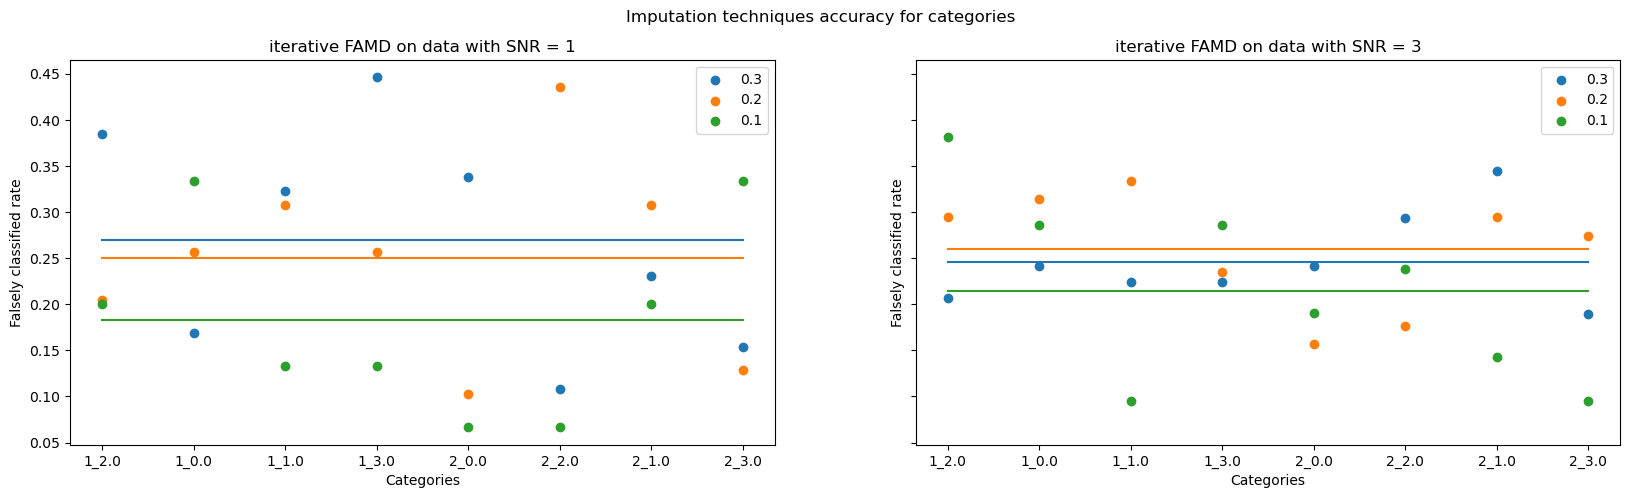

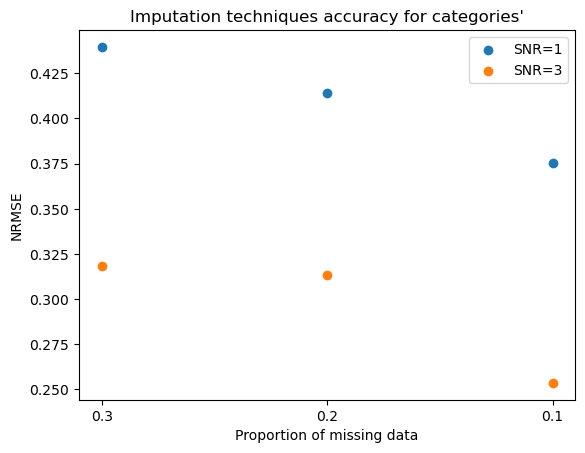

In [80]:
# For categorical variables 
fig, ax = plt.subplots(figsize=(20,5),ncols=2, sharey=True)
fig.suptitle('Imputation techniques accuracy for categories')

k1 = dc[:len(dc) - np.array(nb_of_cat_per_var).sum()]
k2 = dc[len(dc) - np.array(nb_of_cat_per_var).sum():]

for i, vect1 in enumerate(fc_rate_1): 
    ax[0].scatter(k2.to_numpy(), vect1, label=np.round(1-proba_non_missing[i], 2))
    ax[0].plot(k2.to_numpy(),np.ones_like(k2.to_numpy())*vect1.mean())
    ax[0].set_ylabel("Falsely classified rate")
    ax[0].set_title("iterative FAMD on data with SNR = 1")
    ax[0].set_xlabel("Categories")
    ax[0].legend()

    vect3 = fc_rate_3[i]
    ax[1].scatter(k2.to_numpy(), vect3, label=np.round(1- proba_non_missing[i],2))
    ax[1].plot(k2.to_numpy(),np.ones_like(k2.to_numpy())*vect3.mean())
    ax[1].set_ylabel("Falsely classified rate")
    ax[1].set_title("iterative FAMD on data with SNR = 3")
    ax[1].set_xlabel("Categories")
    ax[1].legend()
    
fig.savefig('images/synthetic/PFC_categories_prop1.png')
plt.show()

# For continuous variables 
plt.figure ()
proba_missing_str = ["0.3", "0.2", "0.1"]
plt.scatter(proba_missing_str, nrmse_snr1, label='SNR=1')
plt.scatter(proba_missing_str, nrmse_snr3, label='SNR=3')
plt.xlabel("Proportion of missing data")
plt.ylabel("NRMSE")
plt.title("Imputation techniques accuracy for categories'")

fig.savefig('images/synthetic/NRMSE_continuous_prop1.png')
plt.legend()

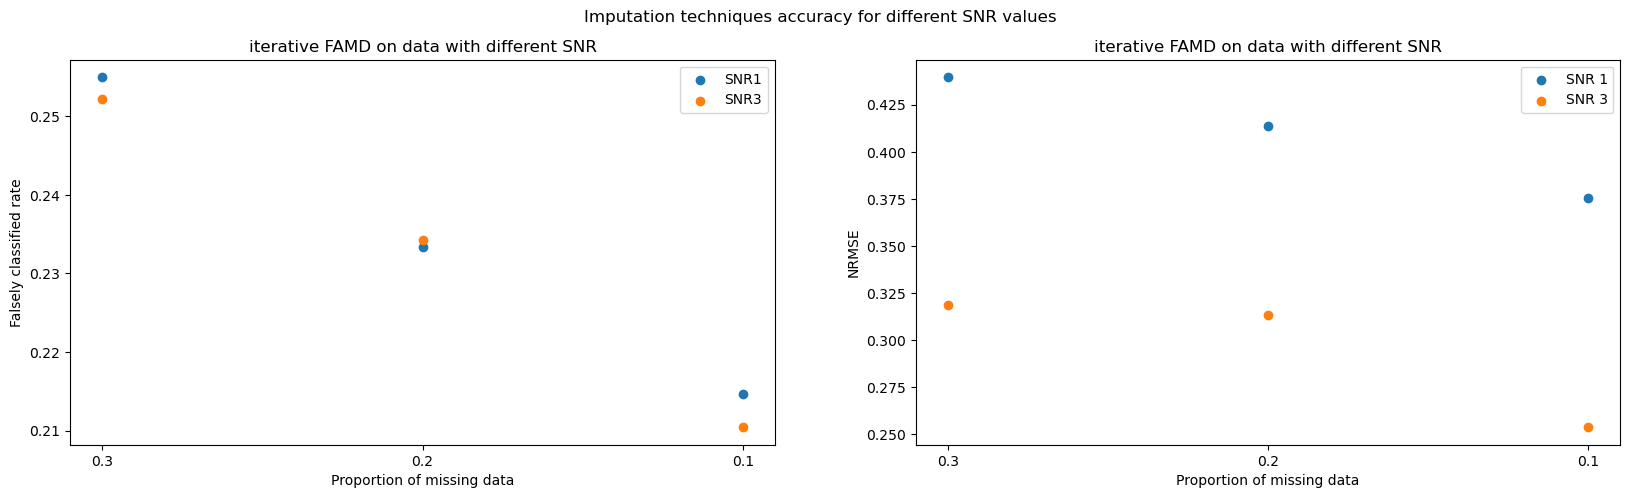

In [81]:
fig, ax = plt.subplots(figsize=(20,5),ncols=2, sharey=False)
fig.suptitle('Imputation techniques accuracy for different SNR values')

ax[0].scatter(proba_missing_str, mean_fc_rate_snr1, label = "SNR1")
ax[0].scatter(proba_missing_str, mean_fc_rate_snr3, label = "SNR3")
ax[0].set_ylabel("Falsely classified rate")
ax[0].set_xlabel("Proportion of missing data")
ax[0].set_title("iterative FAMD on data with different SNR")
ax[0].legend()

ax[1].scatter(proba_missing_str, nrmse_snr1, label = "SNR 1")
ax[1].scatter(proba_missing_str, nrmse_snr3, label = "SNR 3")
ax[1].set_ylabel("NRMSE")
ax[1].set_xlabel("Proportion of missing data")
ax[1].set_title("iterative FAMD on data with different SNR")
ax[1].legend()

fig.savefig('images/synthetic/prop1.png')
plt.show()

#### 2.2 Linear and nonlinear relationships

#### 2.2.a - Parameter initialization

In [82]:
#Parameters of the second linear dataset created in the paper : (3.2.1 Linear and nonlinear relationships)

S = 1   # Underlying number of dimensions
K = [4]  # K[s] = number of times the variable s (s in {1,...,S}) is duplicated in the dataset
cat = 1 # Number of categorical variables
cat_idx = [4] # Index of the categorical variables
nb_of_cat_per_var = [10] # Number of categories for each categorical variable
SNR = 5 # Signal to noise ratio 

##### 2.2.b - Run simulations 

In [83]:
# Create lists where we will save progressively the scores 
nrmse_lin, nrmse_nonlin = [], [] #(for linear and non-linear)
fc_rate_lin, fc_rate_nonlin = [], [] #(for linear and non-linear)

# We run all simulations
for n_sim in range(n_simulations):
    # Linear
    ## Create dataset 
    df_lin = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, SNR = SNR)
    ## Compute iFAMD and metrics 
    fc_rate, nmrse, dc = compute_metrics(df_lin, pd.Index(cat_idx).map(str), n_it, n_components, proba_non_missing)
    ## Save scores 
    fc_rate_lin.append(fc_rate)
    nrmse_lin.append(nmrse)

    # Non-linear
    ## Create dataset
    df_nonlin = df_lin.copy()
    df_nonlin["1"] = df_nonlin["1"]**2
    df_nonlin["2"] = np.cos(df_nonlin["2"])
    ## Compute iFAMD and metrics 
    fc_rate, nmrse, _ = compute_metrics(df_nonlin, pd.Index(cat_idx).map(str), n_it, n_components, proba_non_missing)
    ## Save scores 
    fc_rate_nonlin.append(fc_rate)
    nrmse_nonlin.append(nmrse)


# Normalization of scores over all iterations 
fc_rate_lin, fc_rate_nonlin= np.array(fc_rate_lin).mean(axis=0), np.array(fc_rate_nonlin).mean(axis=0)
nrmse_lin, nrmse_nonlin = np.array(nrmse_lin).mean(axis=0), np.array(nrmse_nonlin).mean(axis=0)

Converged in 7
Converged in 9
Converged in 8
Converged in 7
Converged in 5
Converged in 5
Converged in 10
Converged in 11
Converged in 6
Converged in 7
Converged in 6
Converged in 5
Converged in 13
Converged in 11
Converged in 6
Converged in 6
Converged in 6
Converged in 6
Converged in 9
Converged in 8
Converged in 5
Converged in 6
Converged in 6
Converged in 5
Converged in 9
Converged in 9
Converged in 6
Converged in 6
Converged in 5
Converged in 5
Converged in 10
Converged in 5
Converged in 6
Converged in 7
Converged in 7
Converged in 6
Converged in 11
Converged in 7
Converged in 6
Converged in 7
Converged in 6
Converged in 4
Converged in 16
Converged in 10
Converged in 4
Converged in 7
Converged in 7
Converged in 5
Converged in 9
Converged in 7
Converged in 6
Converged in 6
Converged in 6
Converged in 5
Converged in 8
Converged in 8
Converged in 6
Converged in 6
Converged in 5
Converged in 5
Converged in 11
Converged in 6
Converged in 4
Converged in 6
Converged in 6
Converged in 5
C

##### 2.2.c- Figures 

In [86]:
# Computation of mean falsely classified rate over categories for a fixed probability of missingness 
mean_fc_rate_lin = [np.mean(vect) for vect in fc_rate_lin]
mean_fc_rate_nonlin = [np.mean(vect) for vect in fc_rate_nonlin]

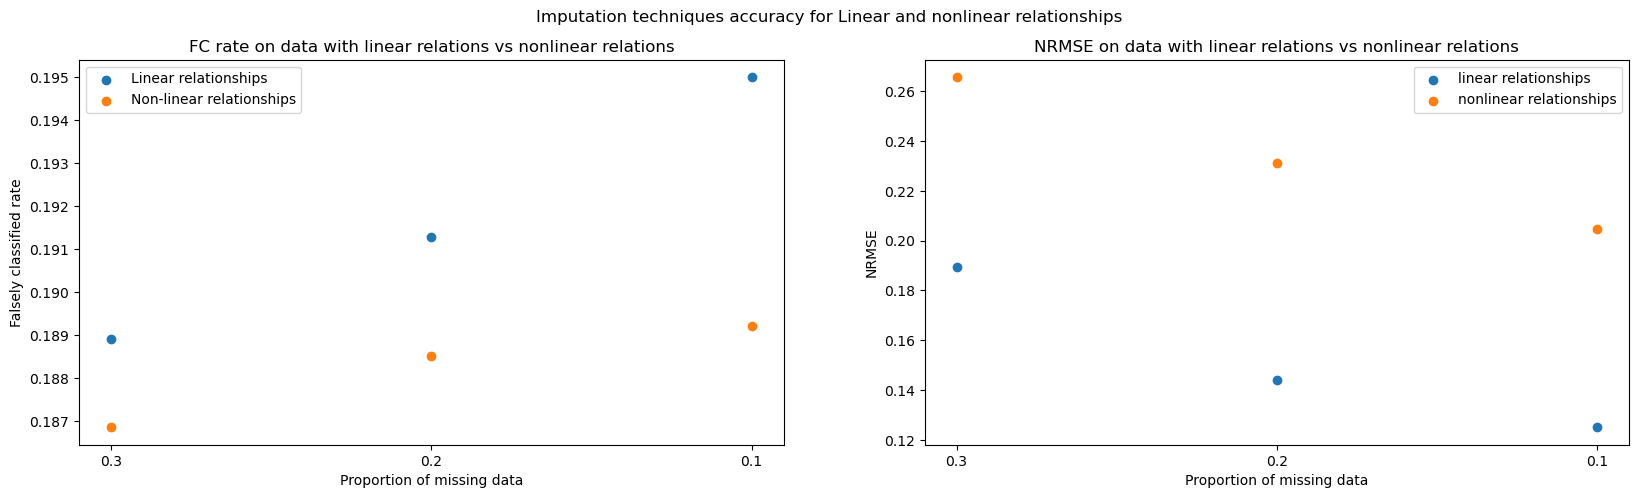

In [87]:
fig, ax = plt.subplots(figsize=(20,5),ncols=2, sharey=False)
fig.suptitle('Imputation techniques accuracy for Linear and nonlinear relationships')

ax[0].scatter(proba_missing_str, mean_fc_rate_lin, label = "Linear relationships")
ax[0].scatter(proba_missing_str, mean_fc_rate_nonlin, label = "Non-linear relationships")
ax[0].set_ylabel("Falsely classified rate")
ax[0].set_xlabel("Proportion of missing data")
ax[0].set_title("FC rate on data with linear relations vs nonlinear relations")
ax[0].legend()

ax[1].scatter(proba_missing_str, nrmse_lin, label = "linear relationships")
ax[1].scatter(proba_missing_str, nrmse_nonlin, label = "nonlinear relationships")
ax[1].set_ylabel("NRMSE")
ax[1].set_xlabel("Proportion of missing data")
ax[1].set_title("NRMSE on data with linear relations vs nonlinear relations")
ax[1].legend()

fig.savefig('images/synthetic/lin_vs_nonlin_prop2.png')
plt.show()

#### 2.3 Imputation of rare categories

##### 2.3.a - Parameter initialization

In [ ]:
# Fixed missingness probability
proba_non_missing = [0.9]

# Categorical variables 
idx_k2 = pd.Index(["2","3","4"])
# Continuous Variables
idx_k1 = pd.Index(["0", "1"])

# Number of individuals 
rare_n = [100, 100, 1000, 1000, 1000, 1000]

# Frequency of each rare category 
rare_f = [0.1, 0.04, 0.1, 0.04, 0.01, 0.004]

##### 2.3.b - Run simulations 

In [18]:
# Create a list where we will save progressively the falsely classified 
rare_fc = []

# For each rare dataframe created 
for i in range(len(rare_f)):
    f = rare_f[i]
    n = rare_n[i]
    fc = []
    # We run all simulations
    for n_sim in range(n_simulations):
        df_rare = create_rare_df(f,n)
        fc_rate, nmrse, idx_j = compute_metrics(df_rare, idx_k2, n_it, n_components, proba_non_missing)
        fc.append(np.mean(fc_rate))
    rare_fc.append(fc)

Converged in 4
Converged in 5
Converged in 4
Converged in 4
Converged in 8
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 5
Converged in 8
Converged in 4
Converged in 4
Converged in 5
Converged in 5
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 8
Converged in 4
Converged in 4
Converged in 5
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 5
Converged in 5
Converged in 5
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 6
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 5
Converged in 5
Converged in 4
Converged in 5
Converged in 4
Converged in 4
Converged in 5
Converged in 6
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 4
Converged in 5
Converged in 4
Converged in 6
Converged in 4
Converged in 6
Converged 

##### 2.2.c- Figures 

In [19]:
# Computation of mean falsely classified rate over categories for a fixed probability of missingness 
mean_rare_fc = [np.mean(vect) for vect in rare_fc]

In [20]:
# Creation of a dataframe presenting the falsely classified rate according to the number of individuals and proportion of rare individuals.  
rare_fc = [rare_n , rare_f, mean_rare_fc]

rare_fc = np.array(rare_fc)
columns = ('Number of individuals', 'Proportion of rare categories', 'Falsely Classified Rate')
rare_fc_df = pd.DataFrame(rare_fc.T, columns = columns) # Dataframe creation 
rare_fc_df

,Number of individuals,Proportion of rare categories,Falsely Classified Rate
0,100.0,0.100,0.156909
1,100.0,0.040,0.153159
2,1000.0,0.100,0.157879
3,1000.0,0.040,0.151779
4,1000.0,0.010,0.149906
5,1000.0,0.004,0.149677


The results do not match with the paper results because the missing values were injected the wrong way.
We need to adapt the create_missingness function for this case.

#### 2.4 - Choice number of dimensions 

##### 2.4.a - Parameter initialization 

In [91]:
n = 100 # Number of samples
S = 2   # Underlying dimensions
K = [7,3]  # K[s] = number of times the variable s (s in {1,...,S}) is duplicated in the dataset
cat = 6 # Number of categorical variables
cat_idx = [5,6,7,8,10,11] # Index of the categorical variables
nb_of_cat_per_var = np.full((cat),3) # Number of categories for each categorical variable

##### 2.4.b - Run simulations

In [92]:
# Different number of components for reconstruction 
n_components = [2, 4,5,6,7,10]

# Create a list where we will save progressively the falsely classified 
fc_rate_nc_tot1, fc_rate_nc_tot3 = [], []
nmrse_nc1_tot, nmrse_nc3_tot = [], []

# We run all simulations
for n_sim in range(n_simulations): 
    fc_rate_nc1, fc_rate_nc3 = np.zeros((len(n_components))), np.zeros((len(n_components)))
    nmrse_nc1, nmrse_nc3 = np.zeros(len(n_components)), np.zeros(len(n_components))
    # For each number of components 
    for i,n_c in enumerate(n_components): 
        # For SNR = 1: 
        ## Create dataset 
        df_3_4_snr1 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, SNR = 1)
        ## Compute iFAMD and metrics 
        fc_rate1, nmrse1, dc = compute_metrics(df_3_4_snr1, pd.Index(cat_idx).map(str), n_it, n_c, proba_non_missing)
        ## Save scores 
        fc_rate_nc1[i] = np.array(fc_rate1).mean()
        nmrse_nc1[i] = np.array(nmrse1).mean()

        # For SNR·= 3: 
        ## Create dataset 
        df_3_4_snr3 = create_dataset(n, S, K, cat, cat_idx, nb_of_cat_per_var, SNR = 3)
        ## Compute iFAMD and metrics 
        fc_rate3, nmrse3, dc = compute_metrics(df_3_4_snr3, pd.Index(cat_idx).map(str), n_it, n_c, proba_non_missing)
        ## Save scores 
        fc_rate_nc3[i] = np.array(fc_rate3).mean()
        nmrse_nc3[i] = np.array(nrmse_3).mean() 

        if n_c==10: 
            fc_rate_nc_tot1.append(fc_rate_nc1)
            fc_rate_nc_tot3.append(fc_rate_nc3)
            nmrse_nc1_tot.append(nmrse_nc1)
            nmrse_nc3_tot.append(nmrse_nc3)

fc_rate_nc_tot1, fc_rate_nc_tot3 = np.array(fc_rate_nc_tot1), np.array(fc_rate_nc_tot3)
nmrse_nc1_tot, nmrse_nc3_tot = np.array(nmrse_nc1_tot), np.array(nmrse_nc3_tot)

Converged in 11
Converged in 7
Converged in 4
Converged in 7
Converged in 5
Converged in 4
Converged in 15
Converged in 32
Converged in 12
Converged in 9
Converged in 7
Converged in 6
Converged in 14
Converged in 12
Converged in 12
Converged in 10
Converged in 8
Converged in 5
Converged in 22
Converged in 12
Converged in 8
Converged in 10


#### 2.4.c Figures

In [ ]:
# Normalization of scores over all iterations 
fc_rate_nc1_mean = fc_rate_nc_tot1.mean(axis=0)
fc_rate_nc3_mean = fc_rate_nc_tot3.mean(axis=0)

nmrse_nc1_mean = nmrse_nc1_tot.mean(axis=0)
nmrse_nc3_mean =  nmrse_nc3_tot.mean(axis=0)

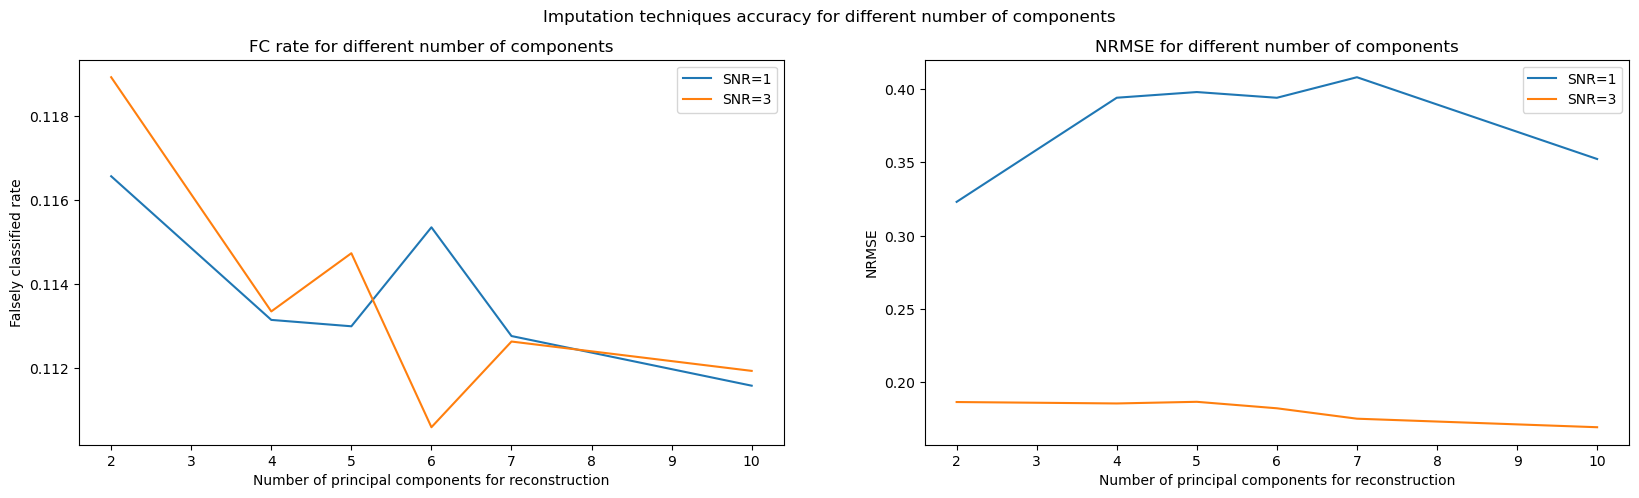

In [ ]:
fig, ax = plt.subplots(figsize=(20,5),ncols=2, sharey=False)
fig.suptitle('Imputation techniques accuracy for different number of components')

ax[0].plot(n_components, fc_rate_nc1_mean, label = "SNR=1")
ax[0].plot(n_components, fc_rate_nc3_mean, label = "SNR=3")
ax[0].set_ylabel("Falsely classified rate")
ax[0].set_xlabel("Number of principal components for reconstruction")
ax[0].set_title("FC rate for different number of components")
ax[0].legend()

ax[1].plot(n_components, nmrse_nc1_mean, label = "SNR=1")
ax[1].plot(n_components, nmrse_nc3_mean, label = "SNR=3")
ax[1].set_ylabel("NRMSE")
ax[1].set_xlabel("Number of principal components for reconstruction")
ax[1].set_title("NRMSE for different number of components")
ax[1].legend()

fig.savefig('images/synthetic/nb_dims_prop4.png')
plt.show()